### Ocean Wave Height Prediction of next 7 days 


In [1]:
# Step 0: Environment Setup and Library Imports
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg') # Use non-GUI backend for training visualizations
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
import warnings
import os
import time
import pickle

warnings.filterwarnings('ignore')
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU Name {i}: {torch.cuda.get_device_name(i)}")
    torch.cuda.empty_cache()

PyTorch Version: 2.5.1
Using device: cuda
Number of GPUs available: 2
GPU Name 0: NVIDIA GeForce GTX 1080 Ti
GPU Name 1: NVIDIA GeForce GTX 1080 Ti


In [16]:
# Step 1 & 2: Data Loading & Preprocessing
# ------------------------------------------------------------------------------

training_data_path1 = r'dAtA\cmems_mod_ibi_wav_my_0.027deg_PT1H-i_multi-vars_11.00W-8.53W_38.50N-40.47N_2020-01-01-2023-12-30.nc'
# training_data_path2 = r'dAtA\cmems_mod_ibi_wav_my-aflux_0.027deg_P1H-i_TLA-TAUX-TAUY_11.00W-8.53W_38.50N-40.47N_2020-01-01-2023-12-30.nc'
training_data_path_static = r'dAtA\cmems_mod_ibi_wav_my_0.027deg_static_1756186965833.nc'

print(f"\n--- Loading training data ---")

ds_static = xr.open_dataset(training_data_path_static, engine="netcdf4")
static_mask = ds_static['mask'].values
static_depth = ds_static['deptho'].values
ds1 = xr.open_dataset(training_data_path1, engine="netcdf4")
# ds2 = xr.open_dataset(training_data_path2, engine="netcdf4")
# ds2_unmasked = ds2.where(~ds2.isnull(), drop=True)
# ds_train = xr.merge([ds1, ds2_unmasked], combine_attrs='drop')

ds_train = ds1.sel(time=slice('2020-01-01', '2022-12-31'))
ds_val = ds1.sel(time=slice('2023-01-01', '2023-06-30'))
ds_test = ds1.sel(time=slice('2023-07-01', '2023-12-30'))

ds_train['VSDmag'] = np.sqrt(ds_train['VSDX']**2 + ds_train['VSDY']**2)          # Add a new column called VSDmag which is sqrt of VSDX^2 + VSDY^2

# --- Feature Engineering & Data Preparation ---
target_var = 'VCMX'
initial_feature_vars = ['VSDmag', 'VTM10', 'VTM02', 'VTM01_WW', 'VTM01_SW1', 'VMXL', 'VHM0_WW', 'VHM0_SW1']
all_vars_to_process = [target_var] + initial_feature_vars

# --- Fit Scalers ONLY on the training data ---
print("\n--- Fitting scalers on TRAINING data only... ---")
scalers = {}
chunk_size = 1000
for var in all_vars_to_process:
    if var == 'VMDR': continue
    scaler = MinMaxScaler()
    for i in tqdm(range(0, ds_train.dims['time'], chunk_size), desc=f"Fitting scaler for {var}"):
        chunk = ds_train[var].isel(time=slice(i, i + chunk_size)).fillna(0).values.reshape(-1, 1)
        scaler.partial_fit(chunk)
    scalers[var] = scaler
    
static_scalers = {}
static_scalers['deptho'] = MinMaxScaler()
static_depth_scaled = static_scalers['deptho'].fit_transform(static_depth.reshape(-1, 1)).reshape(static_depth.shape)
static_data_tensor = np.stack([static_mask, static_depth_scaled], axis=0).astype(np.float32)

print("Scalers fitted successfully.")


--- Loading training data ---

--- Fitting scalers on TRAINING data only... ---


Fitting scaler for VHM0_SW1: 100%|██████████| 27/27 [00:09<00:00,  2.85it/s]

Scalers fitted successfully.


In [32]:
# Step 3: PyTorch Lazy Dataset and DataLoaders
# ------------------------------------------------------------------------------
class WaveDataset_Lazy(Dataset):
    def __init__(self, ds, feature_vars, target_var, scalers, static_data_tensor, lookback=48, forecast_horizon=168):
        self.ds = ds
        self.feature_vars = feature_vars
        self.target_var = target_var
        self.scalers = scalers
        self.static_data_tensor = static_data_tensor # New: Pass static data to the dataset
        self.lookback = lookback
        self.forecast_horizon = forecast_horizon
        self.ds_length = len(self.ds['time'])
        self.n_sequences = self.ds_length - (self.lookback + self.forecast_horizon)
        self.all_vars = [target_var] + feature_vars

    def __len__(self):
        return self.n_sequences


    def __getitem__(self, idx):
        seq_start_idx = idx
        seq_end_idx = seq_start_idx + self.lookback + self.forecast_horizon
        data_slice = self.ds.isel(time=slice(seq_start_idx, seq_end_idx))

        data_slice = data_slice.fillna(0)

        for var, scaler in self.scalers.items():
            if var not in data_slice.variables:
                continue
            var_data = data_slice[var].values
            original_shape = var_data.shape
            var_data_flattened = var_data.reshape(-1, 1)
            var_scaled_flattened = scaler.transform(var_data_flattened)
            var_scaled_reshaped = var_scaled_flattened.reshape(original_shape)
            data_slice[var] = (data_slice[var].dims, var_scaled_reshaped)

        # --- Get the time-varying features and add a channel dimension ---
        # The new shape of each array will be (lookback, 1, lat, lon)
        features_list = [
            data_slice[var].isel(time=slice(0, self.lookback)).values[..., np.newaxis, :, :] 
            for var in self.feature_vars
        ]
        
        # --- Prepare the static data ---
        # The shape is already (2, lat, lon) so we add a new time dimension
        static_data_with_time = np.tile(self.static_data_tensor[np.newaxis, ...], (self.lookback, 1, 1, 1))

        # --- Concatenate all features along the channel dimension (axis=1) ---
        # We now combine a list of (lookback, 1, lat, lon) tensors and a
        # (lookback, 2, lat, lon) tensor into a single tensor.
        all_features = np.concatenate(features_list + [static_data_with_time], axis=1).astype(np.float32)

        y = data_slice[self.target_var].isel(time=slice(self.lookback, self.lookback + self.forecast_horizon)).values.astype(np.float32)

        return torch.from_numpy(all_features.transpose(1, 0, 2, 3)), torch.from_numpy(y)

# Instantiate DataLoaders
# Assuming ds_train, ds_val, ds_test, initial_feature_vars, scalers are defined
lookback_hours = 48
forecast_hours = 168
batch_size = 8
# The dataset now receives the static data tensor
train_dataset = WaveDataset_Lazy(ds_train, initial_feature_vars, target_var, scalers, static_data_tensor, lookback=lookback_hours, forecast_horizon=forecast_hours)
val_dataset = WaveDataset_Lazy(ds_val, initial_feature_vars, target_var, scalers, static_data_tensor, lookback=lookback_hours, forecast_horizon=forecast_hours)
test_dataset = WaveDataset_Lazy(ds_test, initial_feature_vars, target_var, scalers, static_data_tensor, lookback=lookback_hours, forecast_horizon=forecast_hours)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print("DataLoaders instantiated successfully.")

DataLoaders instantiated successfully.


In [33]:
# [A guide to time series splitting in Python](https://www.youtube.com/watch?v=27SGf2w62ic) is relevant because it explains how to properly split time series data to prevent data leakage and ensure a fair evaluation of your model's performance.

In [ ]:
# Step 4: Build the ConvLSTM Model
# ------------------------------------------------------------------------------
print("\n--- Step 4: Building the ConvLSTM Model ---")

warnings.filterwarnings('ignore')

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2
        self.bias = bias
        self.conv = nn.Conv2d(self.input_dim + self.hidden_dim, 4 * self.hidden_dim, self.kernel_size, padding=self.padding, bias=self.bias)
    
    def forward(self, x, h_c):
        h, c = h_c
        combined = torch.cat([x, h], dim=1)
        cc = self.conv(combined)
        i, f, o, g = torch.split(cc, self.hidden_dim, dim=1)
        i, f, o, g = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o), torch.tanh(g)
        c_n = f * c + i * g
        h_n = o * torch.tanh(c_n)
        return h_n, c_n
    
    def init_hidden(self, b, h, w, d):
        return (torch.zeros(b, self.hidden_dim, h, w, device=d), torch.zeros(b, self.hidden_dim, h, w, device=d))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=True, bias=True):
        super(ConvLSTM, self).__init__()
        self.batch_first = batch_first
        self.num_layers = num_layers
        
        # Ensure hidden_dim is a list for multi-layer support
        hidden_dims = [hidden_dim] * num_layers if isinstance(hidden_dim, int) else hidden_dim
        
        cell_list = []
        for i in range(self.num_layers):
            current_input_dim = input_dim if i == 0 else hidden_dims[i - 1]
            cell_list.append(ConvLSTMCell(current_input_dim, hidden_dims[i], kernel_size, bias))
        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, x, h_c=None):
        if not self.batch_first:
            x.permute(1, 0, 2, 3, 4)
        
        b, s_l, _, h, w = x.size()
        h_c = self._init_hidden(b, h, w, x.device) if h_c is None else h_c
        
        cur_in = x
        for l_idx in range(self.num_layers):
            h, c = h_c[l_idx]
            output_inner = []
            for t in range(s_l):
                h, c = self.cell_list[l_idx](cur_in[:, t, :, :, :], [h, c])
                output_inner.append(h)
            cur_in = torch.stack(output_inner, dim=1)
        
        return cur_in, [h, c]

    def _init_hidden(self, b, h, w, d):
        init_states = []
        for cell in self.cell_list:
            init_states.append(cell.init_hidden(b, h, w, d))
        return init_states

class ConvLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], kernel_size=(3, 3)):
        super(ConvLSTMNet, self).__init__()
        self.cl1 = ConvLSTM(input_dim, hidden_dims[0], kernel_size, 1, batch_first=True)
        self.cl2 = ConvLSTM(hidden_dims[0], hidden_dims[1], kernel_size, 1, batch_first=True)
        self.output_conv = nn.Conv2d(hidden_dims[1], 1, kernel_size=(1, 1), padding='same')

    def forward(self, x_seq):
        l1_o, _ = self.cl1(x_seq)
        l2_o, _ = self.cl2(l1_o)
        
        return self.output_conv(l2_o[:, -1, :, :, :])

    def _init_hidden(self, b, i_s, d):
        return [c.init_hidden(b, i_s, d) for c in self.cell_list]

class ConvLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], kernel_size=(3, 3)):
        super(ConvLSTMNet, self).__init__()
        # input_dim here should be 10
        self.cl1 = ConvLSTM(input_dim, hidden_dims[0], kernel_size, 1, batch_first=True)
        self.cl2 = ConvLSTM(hidden_dims[0], hidden_dims[1], kernel_size, 1, batch_first=True)
        self.output_conv = nn.Conv2d(hidden_dims[1], 1, kernel_size=(1, 1), padding='same')

    def forward(self, x_seq):
        # The input x_seq already contains the concatenated static data
        l1_o, _ = self.cl1(x_seq)
        l2_o, _ = self.cl2(l1_o)
        
        return self.output_conv(l2_o[:, -1, :, :, :])

# Calculate input channels correctly
n_feature_channels = len(initial_feature_vars)   # e.g., 8
n_static_channels = static_data_tensor.shape[0]  # e.g., 2 (mask + depth)
input_channels = n_feature_channels + n_static_channels  # e.g., 10

print(f"ConvLSTM input channels: {input_channels}")

model = ConvLSTMNet(input_dim=input_channels)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(device)
print(f"Model built and enabled for multi-GPU. Total Input Channels: {new_input_dim}")

# Step 5: Train and Visualize with Early Stopping
# ------------------------------------------------------------------------------

def weighted_mse_loss(output, target, weight_threshold=0.8):
    mse = (output - target)**2
    # Ensure dimensions match for the weights
    weights = torch.where(target > weight_threshold, 2.0, 1.0)
    return torch.mean(weights * mse)

def train_model(model, train_loader, val_loader, device, epochs=50, model_path='best_convlstm_model.pth'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = weighted_mse_loss
    best_val_loss = float('inf')
    scaler = torch.cuda.amp.GradScaler()
    patience = 5
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': []}

    print("\n--- Step 5: Starting Model Training with Early Stopping ---")
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        
        for X, y in train_pbar:
            X, y = X.to(device), y.to(device)
            
            with torch.cuda.amp.autocast():
                # Teacher forcing: predict the next single step based on the true input sequence
                predicted_step = model(X)
                # The target is the first time step of the forecast horizon.
                # y is (B, T, H, W), so y[:, 0, :, :] is (B, H, W)
                loss = loss_fn(predicted_step, y[:, 0, :, :])
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item():.6f}'})
        
        model.eval()
        total_val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
        with torch.no_grad():
            for X_v, y_v in val_pbar:
                X_v, y_v = X_v.to(device), y_v.to(device)
                
                # Single-step prediction for validation, matching the training logic
                val_predictions = model(X_v)
                # Compare the single predicted step with the first target step
                val_loss = loss_fn(val_predictions, y_v[:, 0, :, :])
                total_val_loss += val_loss.item()
                val_pbar.set_postfix({'loss': f'{val_loss.item():.6f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        print(f"Epoch {epoch+1} Summary|Avg Train Loss:{avg_train_loss:.6f}|Avg Val Loss:{avg_val_loss:.6f}|Time:{time.time()-start_time:.2f}s")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Unwrap the model if it's a DataParallel object before saving
            state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save(state_dict, model_path)
            print(f"  -> ✅ Validation loss improved. New best model saved (Val Loss: {best_val_loss:.6f})")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ Validation loss did not improve. Counter: {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print(f"\n--- Early stopping triggered after {patience} epochs with no improvement. ---")
            break
            
    print("\n--- Training finished! ---")
    print(f"Loading best model from epoch with validation loss: {best_val_loss:.6f}")
    if isinstance(model, nn.DataParallel):
        model.module.load_state_dict(torch.load(model_path))
    else:
        model.load_state_dict(torch.load(model_path))
    
    return model, history

# Call the function with the corrected code
trained_model, training_history = train_model(model, train_loader, val_loader, device)



--- Step 4: Building the ConvLSTM Model ---
Model built and enabled for multi-GPU. Total Input Channels: 10

--- Step 5: Starting Model Training with Early Stopping ---


Epoch 1/50 [Training]:   0%|          | 0/3261 [00:26<?, ?it/s]


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "c:\Users\user\.conda\envs\gpu-env\lib\site-packages\torch\nn\parallel\parallel_apply.py", line 96, in _worker
    output = module(*input, **kwargs)
  File "c:\Users\user\.conda\envs\gpu-env\lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\Users\user\.conda\envs\gpu-env\lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_22296\2884056326.py", line 95, in forward
    l1_o, _ = self.cl1(x_seq)
  File "c:\Users\user\.conda\envs\gpu-env\lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\Users\user\.conda\envs\gpu-env\lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_22296\2884056326.py", line 57, in forward
    h, c = self.cell_list[l_idx](cur_in[:, t, :, :, :], [h, c])
  File "c:\Users\user\.conda\envs\gpu-env\lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\Users\user\.conda\envs\gpu-env\lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_22296\2884056326.py", line 20, in forward
    cc = self.conv(combined)
  File "c:\Users\user\.conda\envs\gpu-env\lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\Users\user\.conda\envs\gpu-env\lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "c:\Users\user\.conda\envs\gpu-env\lib\site-packages\torch\nn\modules\conv.py", line 554, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "c:\Users\user\.conda\envs\gpu-env\lib\site-packages\torch\nn\modules\conv.py", line 549, in _conv_forward
    return F.conv2d(
RuntimeError: Given groups=1, weight of size [256, 74, 3, 3], expected input[4, 112, 72, 90] to have 74 channels, but got 112 channels instead


In [4]:
# ==============================================================================
# Fixed Code
# ==============================================================================

# Step 0: Environment Setup and Library Imports
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
import warnings
import os
import time
import pickle

warnings.filterwarnings('ignore')
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU Name {i}: {torch.cuda.get_device_name(i)}")
    torch.cuda.empty_cache()

# Step 1 & 2: Data Loading & Preprocessing
# ------------------------------------------------------------------------------

training_data_path1 = r'dAtA\cmems_mod_ibi_wav_my_0.027deg_PT1H-i_multi-vars_11.00W-8.53W_38.50N-40.47N_2020-01-01-2023-12-30.nc'
training_data_path_static = r'dAtA\cmems_mod_ibi_wav_my_0.027deg_static_1756186965833.nc'

print(f"\n--- Loading training data ---")

ds_static = xr.open_dataset(training_data_path_static, engine="netcdf4")
static_mask = ds_static['mask'].values
static_depth = ds_static['deptho'].values
ds1 = xr.open_dataset(training_data_path1, engine="netcdf4")

ds_train = ds1.sel(time=slice('2020-01-01', '2022-12-31'))
ds_val = ds1.sel(time=slice('2023-01-01', '2023-06-30'))
ds_test = ds1.sel(time=slice('2023-07-01', '2023-12-30'))

ds_train['VSDmag'] = np.sqrt(ds_train['VSDX']**2 + ds_train['VSDY']**2)
ds_val['VSDmag'] = np.sqrt(ds_val['VSDX']**2 + ds_val['VSDY']**2)
ds_test['VSDmag'] = np.sqrt(ds_test['VSDX']**2 + ds_test['VSDY']**2)

# --- Feature Engineering & Data Preparation ---
target_var = 'VCMX'
initial_feature_vars = ['VSDmag', 'VTM10', 'VTM02', 'VTM01_WW', 'VTM01_SW1', 'VMXL', 'VHM0_WW', 'VHM0_SW1']
all_vars_to_process = [target_var] + initial_feature_vars

# --- Fit Scalers ONLY on the training data ---
print("\n--- Fitting scalers on TRAINING data only... ---")
scalers = {}
chunk_size = 1000
for var in all_vars_to_process:
    if var == 'VMDR': continue
    scaler = MinMaxScaler()
    for i in tqdm(range(0, ds_train.dims['time'], chunk_size), desc=f"Fitting scaler for {var}"):
        chunk = ds_train[var].isel(time=slice(i, i + chunk_size)).fillna(0).values.reshape(-1, 1)
        scaler.partial_fit(chunk)
    scalers[var] = scaler
    
static_scalers = {}
static_scalers['deptho'] = MinMaxScaler()
static_depth_scaled = static_scalers['deptho'].fit_transform(static_depth.reshape(-1, 1)).reshape(static_depth.shape)
static_data_tensor = np.stack([static_mask, static_depth_scaled], axis=0).astype(np.float32)

print("Scalers fitted successfully.")

PyTorch Version: 2.5.1
Using device: cuda
Number of GPUs available: 2
GPU Name 0: NVIDIA GeForce GTX 1080 Ti
GPU Name 1: NVIDIA GeForce GTX 1080 Ti

--- Loading training data ---

--- Fitting scalers on TRAINING data only... ---


Fitting scaler for VCMX:   0%|          | 0/27 [00:00<?, ?it/s]

Fitting scaler for VSDmag:   0%|          | 0/27 [00:00<?, ?it/s]

Fitting scaler for VTM10:   0%|          | 0/27 [00:00<?, ?it/s]

Fitting scaler for VTM02:   0%|          | 0/27 [00:00<?, ?it/s]

Fitting scaler for VTM01_WW:   0%|          | 0/27 [00:00<?, ?it/s]

Fitting scaler for VTM01_SW1:   0%|          | 0/27 [00:00<?, ?it/s]

Fitting scaler for VMXL:   0%|          | 0/27 [00:00<?, ?it/s]

Fitting scaler for VHM0_WW:   0%|          | 0/27 [00:00<?, ?it/s]

Fitting scaler for VHM0_SW1:   0%|          | 0/27 [00:00<?, ?it/s]

Scalers fitted successfully.


In [15]:
# --- Corrected Dataset Class for ConvLSTM ---
class WaveDataset(Dataset):
    def __init__(self, ds, static_data_tensor, input_seq_len, output_seq_len, scalers, target_var, feature_vars, device):
        self.ds = ds
        self.static_data_tensor = torch.from_numpy(static_data_tensor).to(device)
        self.input_seq_len = input_seq_len
        self.output_seq_len = output_seq_len
        self.scalers = scalers
        self.target_var = target_var
        self.feature_vars = feature_vars
        self.device = device
        
        self.num_times = len(self.ds['time'])
        
    def __len__(self):
        return self.num_times - self.input_seq_len - self.output_seq_len + 1

    def __getitem__(self, idx):
        # Time slices
        input_slice = slice(idx, idx + self.input_seq_len)
        output_slice = slice(idx + self.input_seq_len, idx + self.input_seq_len + self.output_seq_len)

        # Prepare input data (features)
        input_data = []
        for var in self.feature_vars:
            data = self.ds[var].isel(time=input_slice).fillna(0).values
            data = self.scalers[var].transform(data.reshape(-1, 1)).reshape(self.input_seq_len, data.shape[1], data.shape[2])
            input_data.append(data)
        
        # Add static data to input
        # Static data is constant over time, so we need to add a time dimension to it
        static_data_expanded = self.static_data_tensor.unsqueeze(0).repeat(self.input_seq_len, 1, 1, 1)

        # Stack dynamic features along a new channel dimension
        input_data_stack = np.stack(input_data, axis=1) # Shape: (time, channels, lat, lon)
        
        # Concatenate static and dynamic data along the channel dimension
        input_tensor_np = np.concatenate((input_data_stack, static_data_expanded.cpu().numpy()), axis=1)

        # Prepare target data
        target_data = self.ds[self.target_var].isel(time=output_slice).fillna(0).values
        target_data_scaled = self.scalers[self.target_var].transform(target_data.reshape(-1, 1)).reshape(self.output_seq_len, target_data.shape[1], target_data.shape[2])
        
        # Convert to tensors
        input_tensor = torch.from_numpy(input_tensor_np).float().to(self.device)
        target_tensor = torch.from_numpy(target_data_scaled).unsqueeze(1).float().to(self.device) # Add channel dimension for target
        
        return input_tensor, target_tensor

In [18]:
# --- ConvLSTM Model Definition ---
# --- ConvLSTM Model Definition ---
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        
        Parameters
        ----------
        input_dim: int 
            Number of channels of input tensor.
        hidden_dim: int 
            Number of channels of hidden state.
        kernel_size: (int, int) 
            Size of the convolutional kernel.
        bias: bool 
            Whether or not to add the bias.
        """
        super(ConvLSTMCell, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2 # Fixed this line
        self.bias = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        
        # concatenate along channel axis
        combined = torch.cat([input_tensor, h_cur], dim=1)
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

# --- Corrected ConvLSTM Model Definition ---
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, output_seq_len, batch_first=True, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()
        self._check_kernel_size_consistency(kernel_size)
        
        self.input_dim = input_dim
        self.hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        self.kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        self.output_seq_len = output_seq_len
        
        cell_list = []
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]
            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)
        self.final_conv = nn.Conv2d(in_channels=self.hidden_dim[-1],
                                    out_channels=1,
                                    kernel_size=1)
    
    def forward(self, input_tensor, hidden_state=None):
        if not self.batch_first:
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()
        
        if hidden_state is not None:
            raise NotImplementedError("Hidden state initialization is handled automatically.")
        else:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))
            
        layer_output_list = []
        last_state_list = []
        
        cur_layer_input = input_tensor
        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(cur_layer_input.size(1)):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)
            
            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output
            
            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        pred_list = []
        h_dec, c_dec = last_state_list[-1]
        
        # The next input to the decoder should be the output of the last encoder step, but we need to match
        # the number of channels expected by the ConvLSTMCell for its input tensor.
        # This is the key fix: we need a placeholder input that has the correct dimensions.
        next_input = torch.zeros_like(cur_layer_input[:, -1, :, :, :]).to(input_tensor.device)
        
        for _ in range(self.output_seq_len):
            h_dec, c_dec = self.cell_list[-1](input_tensor=next_input, cur_state=[h_dec, c_dec])
            output_frame = self.final_conv(h_dec)
            pred_list.append(output_frame)
            next_input = output_frame
            
        final_preds = torch.stack(pred_list, dim=1)
        return final_preds
    
    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for layer_idx in range(self.num_layers):
            init_states.append(self.cell_list[layer_idx].init_hidden(batch_size, image_size))
        return init_states
    
    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise TypeError('kernel_size must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [19]:
# --- Hyperparameters ---
INPUT_SEQ_LEN = 24  # Look-back window of 24 hours
OUTPUT_SEQ_LEN = 168 # Forecast 168 hours (7 days)
BATCH_SIZE = 1 # Keep small to avoid CUDA out-of-memory errors
LR = 0.001
NUM_EPOCHS = 10

# --- Data Preparation & Model Instantiation ---
input_channels = len(initial_feature_vars) + static_data_tensor.shape[0] # Features + static channels
hidden_dims = [64, 64] # Can be a list for multiple layers
kernel_sizes = [(3, 3), (3, 3)]
num_layers = len(hidden_dims)

train_dataset = WaveDataset(ds_train, static_data_tensor, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN, scalers, target_var, initial_feature_vars, device)
val_dataset = WaveDataset(ds_val, static_data_tensor, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN, scalers, target_var, initial_feature_vars, device)
test_dataset = WaveDataset(ds_test, static_data_tensor, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN, scalers, target_var, initial_feature_vars, device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = ConvLSTM(input_dim=input_channels,
                 hidden_dim=hidden_dims,
                 kernel_size=kernel_sizes,
                 num_layers=num_layers,
                 output_seq_len=OUTPUT_SEQ_LEN,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- Training Loop with Correct Permutations ---
print("\n--- Starting Training ---")
best_val_loss = float('inf')
model.train()

for epoch in range(NUM_EPOCHS):
    train_loss = 0
    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} Training")):
        # inputs shape from DataLoader: (B, T, C, H, W)
        # targets shape from DataLoader: (B, T, C, H, W)
        
        # Model forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # --- Validation Loop ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} Validation")):
            # inputs shape: (B, T, C, H, W)
            # targets shape: (B, T, C, H, W)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_convlstm_model.pth')
    
    model.train()

print("\n--- Training Complete ---")

# --- Test and Visualization ---
print("\n--- Starting Test and Visualization ---")
model.load_state_dict(torch.load('best_convlstm_model.pth'))
model.eval()

with torch.no_grad():
    test_inputs, test_targets = next(iter(test_loader))
    test_preds = model(test_inputs)

    # Inverse transform
    test_preds_np = test_preds.squeeze(0).squeeze(1).cpu().numpy()
    test_targets_np = test_targets.squeeze(0).squeeze(1).cpu().numpy()

    test_preds_inv = scalers[target_var].inverse_transform(test_preds_np.reshape(-1, 1)).reshape(test_preds_np.shape)
    test_targets_inv = scalers[target_var].inverse_transform(test_targets_np.reshape(-1, 1)).reshape(test_targets_np.shape)

    # Get a specific pixel to visualize
    sample_lat_idx, sample_lon_idx = 50, 50 # Choose a pixel for visualization
    pred_series = test_preds_inv[:, sample_lat_idx, sample_lon_idx]
    gt_series = test_targets_inv[:, sample_lat_idx, sample_lon_idx]

    plt.figure(figsize=(15, 6))
    plt.plot(gt_series, label='Ground Truth', color='blue')
    plt.plot(pred_series, label='ConvLSTM Prediction', color='red', linestyle='--')
    plt.title(f'VCMX Prediction vs. Ground Truth at Lat/Lon ({sample_lat_idx}, {sample_lon_idx})')
    plt.xlabel('Time (Hours)')
    plt.ylabel('VCMX (m/s)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('prediction_vs_ground_truth.png')
    plt.show()

print("Visualization saved as 'prediction_vs_ground_truth.png'")



--- Starting Training ---


Epoch 1/10 Training:   0%|          | 0/26113 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [256, 128, 3, 3], expected input[1, 65, 72, 90] to have 128 channels, but got 65 channels instead

In [ ]:
# ==============================================================================
# Step 6: Plot Training History
# ------------------------------------------------------------------------------
print("\n--- Plotting Training and Validation Loss ---")
plt.figure(figsize=(12, 6))
plt.plot(training_history['train_loss'], label='Training Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

PyTorch Version: 2.5.1
Using device: cuda

--- Loading artifacts for validation... ---
Scalers loaded from 'scalers.pkl'.
Model successfully loaded from 'best_convlstm_model.pth'.

--- Loading validation data from: D:\babe_prediction\cmems_mod_ibi_wav_my_0.027deg_PT1H-i_multi-vars_11.00W-8.53W_38.50N-40.47N_2020-01-01-2023-12-30.nc ---
Validation dataset metadata loaded successfully!
Total available validation samples: 35016
Prepared 5 validation subsets of 3000 time steps each.

--- Step 3: Starting Validation Over 5 Smaller Subsets ---

Validating on subset 1/5 with 3000 samples...


Subset 1:   0%|          | 0/750 [00:00<?, ?it/s]


Validating on subset 2/5 with 3000 samples...


Subset 2:   0%|          | 0/750 [00:00<?, ?it/s]


Validating on subset 3/5 with 3000 samples...


Subset 3:   0%|          | 0/750 [00:00<?, ?it/s]


Validating on subset 4/5 with 3000 samples...


Subset 4:   0%|          | 0/750 [00:00<?, ?it/s]


Validating on subset 5/5 with 3000 samples...


Subset 5:   0%|          | 0/750 [00:00<?, ?it/s]


--- Validation Set Performance ---
  -> Root Mean Squared Error (RMSE): 0.0954 m
  -> Mean Absolute Error (MAE):    0.0536 m

--- Generating visualizations... ---


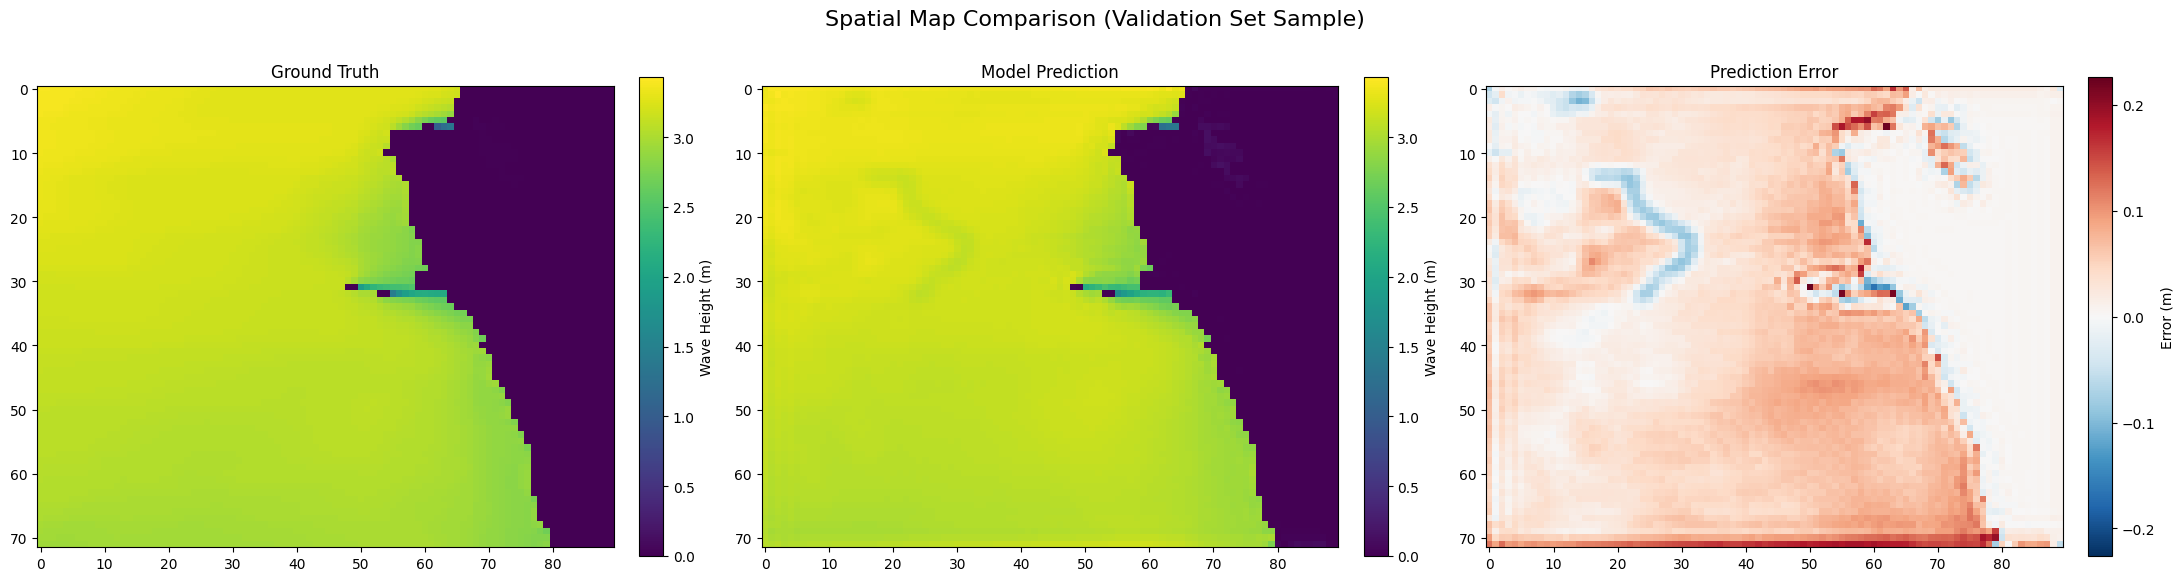

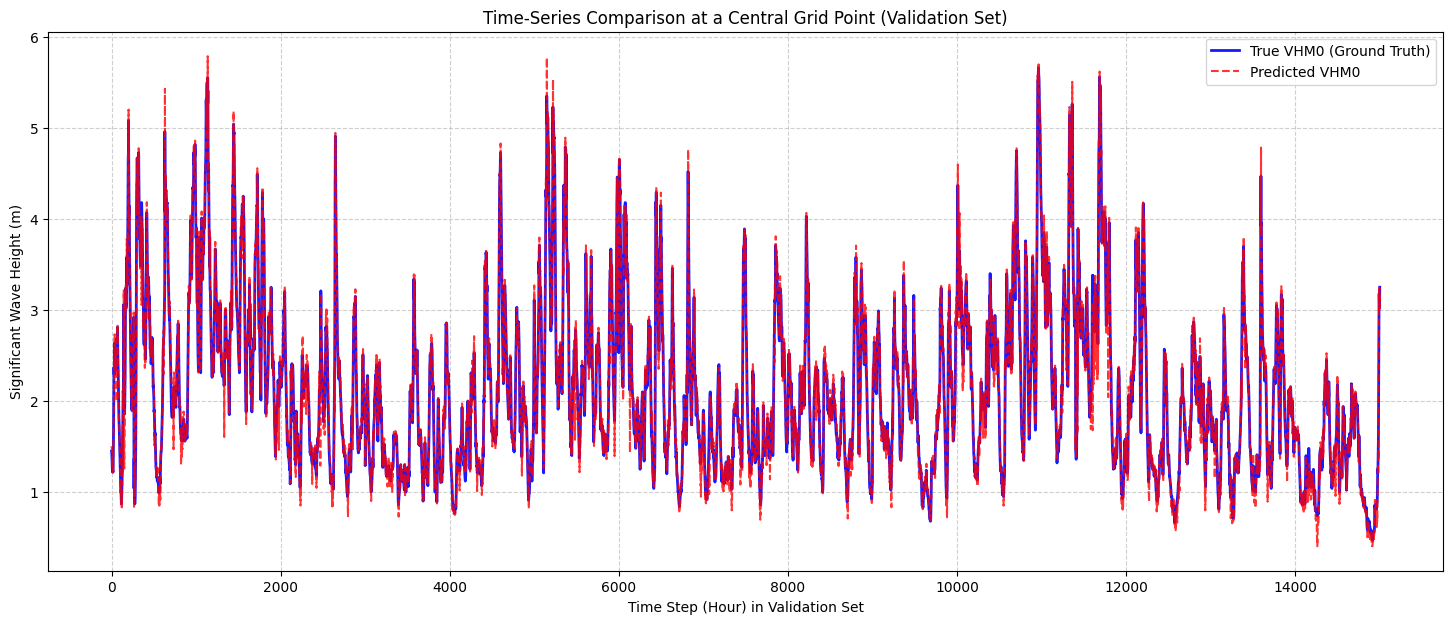

In [ ]:
# ==============================================================================
# Cell 2: All-in-One VALIDATION & EVALUATION Script
# ==============================================================================

# Step 0: Environment Setup and Library Imports
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.auto import tqdm
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Load Scalers, Model Architecture, and Saved Weights
# ------------------------------------------------------------------------------
# --- IMPORTANT: Set the path to your VALIDATION data file ---
validation_data_path = r'D:\babe_prediction\cmems_mod_ibi_wav_my_0.027deg_PT1H-i_multi-vars_11.00W-8.53W_38.50N-40.47N_2020-01-01-2023-12-30.nc'  # <-- UPDATE THIS PATH

print("\n--- Loading artifacts for validation... ---")
# Load the scalers that were fitted on the training data
try:
    with open('scalers.pkl', 'rb') as f:
        scalers = pickle.load(f)
    print("Scalers loaded from 'scalers.pkl'.")
except FileNotFoundError:
    raise RuntimeError("'scalers.pkl' not found. Please run the training cell first.")

# --- You must redefine the model architecture exactly as it was during training ---
target_var = 'VHM0'
final_feature_vars = ['VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR_sin', 'VMDR_cos', 'VTPK', 'VSDX', 'VSDY']

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim, self.hidden_dim, self.kernel_size, self.padding, self.bias = input_dim, hidden_dim, kernel_size, kernel_size[0]//2, bias
        self.conv = nn.Conv2d(self.input_dim + self.hidden_dim, 4 * self.hidden_dim, self.kernel_size, padding=self.padding, bias=self.bias)
    def forward(self, x, h_c):
        h, c = h_c
        cc = self.conv(torch.cat([x, h], dim=1))
        i, f, o, g = torch.split(cc, self.hidden_dim, dim=1)
        i, f, o, g = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o), torch.tanh(g)
        c_n = f * c + i * g
        return o * torch.tanh(c_n), c_n
    def init_hidden(self, b, i_s, d):
        return (torch.zeros(b, self.hidden_dim, *i_s, device=d), torch.zeros(b, self.hidden_dim, *i_s, device=d))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True):
        super(ConvLSTM, self).__init__()
        self.batch_first = batch_first
        self.num_layers = num_layers
        h_d = [hidden_dim] * num_layers if isinstance(hidden_dim, int) else hidden_dim
        self.cell_list = nn.ModuleList([
            ConvLSTMCell(input_dim if i == 0 else h_d[i - 1], h_d[i], kernel_size, bias)
            for i in range(num_layers)
        ])
    def forward(self, x, h_c=None):
        b, _, _, h, w = x.size()
        h_c = self._init_hidden(b, (h, w), x.device) if h_c is None else h_c
        out_l, last_s = [], []
        s_l = x.size(1)
        cur_in = x
        for l_idx in range(self.num_layers):
            h, c = h_c[l_idx]
            out_i = []
            for t in range(s_l):
                h, c = self.cell_list[l_idx](cur_in[:, t, :, :, :], [h, c])
                out_i.append(h)
            l_out = torch.stack(out_i, dim=1)
            cur_in = l_out
            out_l.append(l_out)
            last_s.append([h, c])
        return out_l[-1], last_s[-1]
    def _init_hidden(self, b, i_s, d):
        return [c.init_hidden(b, i_s, d) for c in self.cell_list]

class ConvLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], kernel_size=(3, 3)):
        super(ConvLSTMNet, self).__init__()
        self.cl1 = ConvLSTM(input_dim, hidden_dims[0], kernel_size, 1, batch_first=True)
        self.cl2 = ConvLSTM(hidden_dims[0], hidden_dims[1], kernel_size, 1, batch_first=True)
        self.output_conv = nn.Conv2d(hidden_dims[1], 1, kernel_size=(1, 1), padding='same')
    def forward(self, x):
        l1_o, _ = self.cl1(x)
        l2_o, _ = self.cl2(l1_o)
        return self.output_conv(l2_o[:, -1, :, :, :])

# Load the saved model weights
model_path = 'best_convlstm_model.pth'
final_model = ConvLSTMNet(len(final_feature_vars))
try:
    final_model.load_state_dict(torch.load(model_path, map_location=device))
    if torch.cuda.device_count() > 1:
        final_model = nn.DataParallel(final_model)
    final_model.to(device)
    final_model.eval()
    print(f"Model successfully loaded from '{model_path}'.")
except FileNotFoundError:
    raise RuntimeError(f"'{model_path}' not found. Please run the training cell first.")

# ------------------------------------------------------------------------------
# Step 2: Prepare 5 specific validation chunks of 3000 values each
print(f"\n--- Loading validation data from: {validation_data_path} ---")
try:
    ds_val = xr.open_dataset(validation_data_path, engine="netcdf4")
    print("Validation dataset metadata loaded successfully!")
except FileNotFoundError:
    raise RuntimeError(f"Validation data not found. Please check the path: {validation_data_path}")

lookback_hours = 24
batch_size = 4  # Adjust as needed
n_sequences_val = ds_val.dims['time'] - lookback_hours
print(f"Total available validation samples: {n_sequences_val}")

# Define start indices for the 5 validation chunks
chunk_length = 3000
start_points = [0, 5000, 10000, 15000, 20000]
val_datasets = []
val_loaders = []

for i, start_idx in enumerate(start_points):
    end_idx = start_idx + chunk_length
    if end_idx > n_sequences_val:
        raise ValueError(f"Chunk {i+1} goes beyond available data. Check start index or chunk size.")

    chunk_indices = np.arange(start_idx, end_idx)

    small_dataset = WaveDataset_Lazy(
        validation_data_path, final_feature_vars, target_var,
        chunk_indices, scalers, lookback_hours
    )
    small_loader = DataLoader(small_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    val_datasets.append(small_dataset)
    val_loaders.append(small_loader)

print(f"Prepared {len(val_loaders)} validation subsets of {chunk_length} time steps each.")


# Step 3: Run Validation and Visualize
# ------------------------------------------------------------------------------
print("\n--- Step 3: Starting Validation Over 5 Smaller Subsets ---")
all_y_true, all_y_pred = [], []

with torch.no_grad():
    for i, loader in enumerate(val_loaders):
        print(f"\nValidating on subset {i+1}/5 with {len(loader.dataset)} samples...")
        for X_batch, y_batch in tqdm(loader, desc=f"Subset {i+1}", leave=False):
            y_pred = final_model(X_batch.to(device))
            all_y_true.append(y_batch.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())

y_val_scaled = np.concatenate(all_y_true).squeeze(axis=1)
y_pred_scaled = np.concatenate(all_y_pred).squeeze(axis=1)

# Inverse transform and calculate metrics
target_scaler = scalers[target_var]
y_val_orig = target_scaler.inverse_transform(y_val_scaled.reshape(len(y_val_scaled), -1)).reshape(y_val_scaled.shape)
y_pred_orig = target_scaler.inverse_transform(y_pred_scaled.reshape(len(y_pred_scaled), -1)).reshape(y_pred_scaled.shape)

val_rmse = np.sqrt(mean_squared_error(y_val_orig.flatten(), y_pred_orig.flatten()))
val_mae = mean_absolute_error(y_val_orig.flatten(), y_pred_orig.flatten())

print(f"\n--- Validation Set Performance ---")
print(f"  -> Root Mean Squared Error (RMSE): {val_rmse:.4f} m")
print(f"  -> Mean Absolute Error (MAE):    {val_mae:.4f} m")

# --- Visualizations ---
print("\n--- Generating visualizations... ---")
# Spatial Map Comparison
time_idx_to_plot = len(y_val_orig) // 2
true_map, predicted_map = y_val_orig[time_idx_to_plot], y_pred_orig[time_idx_to_plot]
error_map = predicted_map - true_map
fig, axes = plt.subplots(1, 3, figsize=(22, 6)); fig.suptitle('Spatial Map Comparison (Validation Set Sample)', fontsize=16)
vmax = max(true_map.max(), predicted_map.max())
im1 = axes[0].imshow(true_map, cmap='viridis', vmin=0, vmax=vmax); axes[0].set_title("Ground Truth"); plt.colorbar(im1, ax=axes[0], label='Wave Height (m)', fraction=0.046, pad=0.04)
im2 = axes[1].imshow(predicted_map, cmap='viridis', vmin=0, vmax=vmax); axes[1].set_title("Model Prediction"); plt.colorbar(im2, ax=axes[1], label='Wave Height (m)', fraction=0.046, pad=0.04)
vmax_err = np.abs(error_map).max()
im3 = axes[2].imshow(error_map, cmap='RdBu_r', vmin=-vmax_err, vmax=vmax_err); axes[2].set_title("Prediction Error"); plt.colorbar(im3, ax=axes[2], label='Error (m)', fraction=0.046, pad=0.04)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# Time-Series Plot
central_lat_idx, central_lon_idx = true_map.shape[0] // 2, true_map.shape[1] // 2
true_series, pred_series = y_val_orig[:, central_lat_idx, central_lon_idx], y_pred_orig[:, central_lat_idx, central_lon_idx]
plt.figure(figsize=(18, 7))
plt.plot(true_series, label='True VHM0 (Ground Truth)', color='blue', alpha=0.9, linewidth=2)
plt.plot(pred_series, label='Predicted VHM0', color='red', linestyle='--', alpha=0.8)
plt.title('Time-Series Comparison at a Central Grid Point (Validation Set)')
plt.xlabel('Time Step (Hour) in Validation Set'); plt.ylabel('Significant Wave Height (m)')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.show()


In [ ]:
# ==============================================================================
# Cell 2: All-in-One VALIDATION & EVALUATION Script
# ==============================================================================

# Step 0: Environment Setup and Library Imports
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.auto import tqdm
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Set up global variables from previous cells ---
training_data_path_static = r'dAtA\cmems_mod_ibi_wav_my_0.027deg_static_1756186965833.nc'
target_var = 'VCMX'
initial_feature_vars = ['VSDmag', 'VTM10', 'VTM02', 'VTM01_WW', 'VTM01_SW1', 'VMXL', 'VHM0_WW', 'VHM0_SW1']
lookback_hours = 48
forecast_hours = 168

# --- Load and Preprocess Static Data ---
ds_static = xr.open_dataset(training_data_path_static, engine="netcdf4")
static_mask = ds_static['mask'].values
static_depth = ds_static['deptho'].values

static_scalers = {}
static_scalers['deptho'] = MinMaxScaler()
static_depth_scaled = static_scalers['deptho'].fit_transform(static_depth.reshape(-1, 1)).reshape(static_depth.shape)
static_data_tensor = np.stack([static_mask, static_depth_scaled], axis=0).astype(np.float32)

# Step 1: Load Model Architecture and Saved Weights
# ------------------------------------------------------------------------------
print("\n--- Loading artifacts for evaluation... ---")

# Load the scalers that were fitted on the training data
try:
    with open('scalers.pkl', 'rb') as f:
        scalers = pickle.load(f)
    print("Scalers loaded from 'scalers.pkl'.")
except FileNotFoundError:
    raise RuntimeError("'scalers.pkl' not found. Please run the training cell first.")

# --- You must redefine the model architecture exactly as it was during training ---
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim, self.hidden_dim, self.kernel_size, self.padding, self.bias = input_dim, hidden_dim, kernel_size, kernel_size[0] // 2, bias
        self.conv = nn.Conv2d(self.input_dim + self.hidden_dim, 4 * self.hidden_dim, self.kernel_size, padding=self.padding, bias=self.bias)

    def forward(self, x, h_c):
        h, c = h_c
        combined = torch.cat([x, h], dim=1)
        cc = self.conv(combined)
        i, f, o, g = torch.split(cc, self.hidden_dim, dim=1)
        i, f, o, g = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o), torch.tanh(g)
        c_n = f * c + i * g
        h_n = o * torch.tanh(c_n)
        return h_n, c_n

    def init_hidden(self, b, i_s, d):
        return (torch.zeros(b, self.hidden_dim, *i_s, device=d), torch.zeros(b, self.hidden_dim, *i_s, device=d))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True):
        super(ConvLSTM, self).__init__()
        self.batch_first = batch_first
        self.num_layers = num_layers
        h_d = [hidden_dim] * num_layers if isinstance(hidden_dim, int) else hidden_dim
        self.cell_list = nn.ModuleList([
            ConvLSTMCell(input_dim if i == 0 else h_d[i - 1], h_d[i], kernel_size, bias)
            for i in range(num_layers)
        ])

    def forward(self, x, h_c=None):
        b, s_l, _, h, w = x.size()
        h_c = self._init_hidden(b, (h, w), x.device) if h_c is None else h_c
        out_l, last_s = [], []
        cur_in = x
        for l_idx in range(self.num_layers):
            h, c = h_c[l_idx]
            out_i = []
            for t in range(s_l):
                h, c = self.cell_list[l_idx](cur_in[:, t, :, :, :], [h, c])
                out_i.append(h)
            l_out = torch.stack(out_i, dim=1)
            cur_in = l_out
            out_l.append(l_out)
            last_s.append([h, c])
        return out_l[-1], last_s[-1]

    def _init_hidden(self, b, i_s, d):
        return [c.init_hidden(b, i_s, d) for c in self.cell_list]

class ConvLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], kernel_size=(3, 3), static_input_dim=2):
        super(ConvLSTMNet, self).__init__()
        self.input_dim = input_dim + static_input_dim
        self.cl1 = ConvLSTM(self.input_dim, hidden_dims[0], kernel_size, 1, batch_first=True)
        self.cl2 = ConvLSTM(hidden_dims[0], hidden_dims[1], kernel_size, 1, batch_first=True)
        self.output_conv = nn.Conv2d(hidden_dims[1], 1, kernel_size=(1, 1), padding='same')

    def forward(self, x_seq, static_data, forecast_horizon=168):
        predictions = []
        current_input = x_seq
        
        for _ in range(forecast_horizon):
            last_step_input = current_input[:, -1, :, :, :]
            static_expanded = static_data.unsqueeze(0).repeat(last_step_input.size(0), 1, 1, 1)
            combined_input = torch.cat([last_step_input, static_expanded], dim=1)
            
            l1_o, _ = self.cl1(combined_input.unsqueeze(1))
            l2_o, _ = self.cl2(l1_o)
            
            predicted_step = self.output_conv(l2_o[:, -1, :, :, :])
            predictions.append(predicted_step.squeeze(1))
            
            # Autoregressive update
            new_input_step = predicted_step.unsqueeze(1).repeat(1, 1, 1, 1, 1)
            current_input = torch.cat([current_input[:, 1:, :, :, :], new_input_step], dim=1)

        return torch.stack(predictions, dim=1)

# Load the saved model weights
model_path = 'best_convlstm_model.pth'
final_model = ConvLSTMNet(input_dim=len(initial_feature_vars), static_input_dim=static_data_tensor.shape[0])

try:
    final_model.load_state_dict(torch.load(model_path, map_location=device))
    if torch.cuda.device_count() > 1:
        final_model = nn.DataParallel(final_model)
    final_model.to(device)
    final_model.eval()
    print(f"Model successfully loaded from '{model_path}'.")
except FileNotFoundError:
    raise RuntimeError(f"'{model_path}' not found. Please ensure the training cell was run and saved the model.")

# ------------------------------------------------------------------------------
# Step 2: Run Evaluation on the Test Set
print("\n--- Step 2: Starting Evaluation on the Test Set ---")
# Assuming test_loader is already defined from the previous code cell
try:
    if 'test_loader' not in locals():
        raise NameError("test_loader is not defined. Please run Step 3 from the previous code cell first.")
except NameError as e:
    print(e)
    exit()

all_y_true, all_y_pred = [], []
static_data_tensor = static_data_tensor.to(device)

with torch.no_grad():
    for X_batch, y_batch in tqdm(test_loader, desc="Evaluating on Test Set", leave=False):
        y_pred = final_model(X_batch.to(device), static_data_tensor, forecast_horizon=forecast_hours)
        
        all_y_true.append(y_batch.cpu().numpy())
        all_y_pred.append(y_pred.cpu().numpy())

y_true_stacked = np.concatenate(all_y_true, axis=0)
y_pred_stacked = np.concatenate(all_y_pred, axis=0)

# Reshape arrays for inverse transform
target_scaler = scalers[target_var]
y_true_reshaped = y_true_stacked.reshape(-1, 1)
y_pred_reshaped = y_pred_stacked.reshape(-1, 1)

# Inverse transform to original units
y_true_orig = target_scaler.inverse_transform(y_true_reshaped).reshape(y_true_stacked.shape)
y_pred_orig = target_scaler.inverse_transform(y_pred_reshaped).reshape(y_pred_stacked.shape)

# Calculate final metrics
val_rmse = np.sqrt(mean_squared_error(y_true_orig.flatten(), y_pred_orig.flatten()))
val_mae = mean_absolute_error(y_true_orig.flatten(), y_pred_orig.flatten())

print(f"\n--- Test Set Performance ---")
print(f"  -> Root Mean Squared Error (RMSE): {val_rmse:.4f} m")
print(f"  -> Mean Absolute Error (MAE):      {val_mae:.4f} m")


# Step 3: Run Visualizations
# ------------------------------------------------------------------------------
print("\n--- Generating visualizations... ---")

# Spatial Map Comparison for a single time step
time_idx_to_plot = 100 # Choose a specific time step within the 168-hour forecast
batch_idx_to_plot = 5 # Choose a specific sample from the batch
true_map = y_true_orig[batch_idx_to_plot, time_idx_to_plot, 0, :, :]
predicted_map = y_pred_orig[batch_idx_to_plot, time_idx_to_plot, 0, :, :]
error_map = predicted_map - true_map

fig, axes = plt.subplots(1, 3, figsize=(22, 6))
fig.suptitle('Spatial Map Comparison (Test Set Sample)', fontsize=16)

vmax = max(true_map.max(), predicted_map.max())
im1 = axes[0].imshow(true_map, cmap='viridis', vmin=0, vmax=vmax)
axes[0].set_title("Ground Truth")
plt.colorbar(im1, ax=axes[0], label='Significant Wave Height (m)', fraction=0.046, pad=0.04)

im2 = axes[1].imshow(predicted_map, cmap='viridis', vmin=0, vmax=vmax)
axes[1].set_title("Model Prediction")
plt.colorbar(im2, ax=axes[1], label='Significant Wave Height (m)', fraction=0.046, pad=0.04)

vmax_err = np.abs(error_map).max()
im3 = axes[2].imshow(error_map, cmap='RdBu_r', vmin=-vmax_err, vmax=vmax_err)
axes[2].set_title("Prediction Error")
plt.colorbar(im3, ax=axes[2], label='Error (m)', fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Time-Series Plot for the full 168-hour forecast
central_lat_idx, central_lon_idx = y_true_orig.shape[3] // 2, y_true_orig.shape[4] // 2
true_series = y_true_orig[batch_idx_to_plot, :, 0, central_lat_idx, central_lon_idx]
pred_series = y_pred_orig[batch_idx_to_plot, :, 0, central_lat_idx, central_lon_idx]

plt.figure(figsize=(18, 7))
plt.plot(true_series, label='True VCMX (Ground Truth)', color='blue', alpha=0.9, linewidth=2)
plt.plot(pred_series, label='Predicted VCMX', color='red', linestyle='--', alpha=0.8)
plt.title('Time-Series Comparison at a Central Grid Point (Full 168-Hour Forecast)')
plt.xlabel('Time Step (Hour) in Forecast Horizon'); plt.ylabel('Spectral Wave Velocity Moment (m/s)')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# conda activate gpu-env